<a href="https://colab.research.google.com/github/EmrahYener/DLMAINLPCV01_demo/blob/master/machine_translation_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Translation**

Machine translation (MT) is the task of automatically translating text or speech from one natural language to another. MT is a subfield of NLP that leverages the disciplines of artificial intelligence, information theory, computer science, and statistics.

To build an MT system, we can find different frameworks with statistical machine translation (SMT) and neural machine translation (NMT).

SMT replaces classic rule-based MT systems with models that learn translation through examples. Translations in SMT are generated on the basis of statistical models whose parameters are derived from the analysis of bilingual text corpora.

NMT uses an artificial neural network to learn a statistical
model for MT. Unlike a phrase-based SMT system, an NMT system consists of a single, large neural network that reads a sentence and outputs a translation. Normally an NMT system is built on bidirectional recurrent neural networks (RNNs) using an encoder-attention-decoder architecture  [[1]](#scrollTo=hC1nskpFvqjO).

Since NMT is becoming increasingly popular, there are already many toolkits available. This notebook shows an example of NMT with an encoder-attention-decoder architecture, i.e. a sequence-to-sequence network with an attention mechanism.

Some of the explanations, codes and pictures used in this notebook are taken from [[2]](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html).




## **Machine translation with sequence-to-sequence network**
A recurrent neural network (RNN) is a network that operates on a sequence and uses its own output as input for subsequent steps.

A sequence-to-sequence network (also denoted as seq2seq network or encoder-decoder network) is a model consisting of two RNNs which are denoted as encoder and decoder. The encoder reads an input sequence and outputs a single vector. The decoder reads that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

Consider the sentence “Je ne suis pas le chat noir” → “I am not the black cat”. Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. “chat noir” and “black cat”. Because of the “ne-pas” construction in the French language, there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words.

![seq2seq](https://raw.githubusercontent.com/iubh/DLMAINLPCV01/master/data/nlp/seq2seq.png)


In this example, we will also use an attention mechanism to improve the model efficency. With an attention mechanism, the decoder learns to focus over a specific range of the input sequence.

For machine translation with a seq2seq network, we will apply the following steps:

* Upload dataset
* Import libraries
* Create classes and functions
* Perform model training
* Perform model evaluation
* Visualize attention

For more details about the seq2seq architecture, please refer to [[3]](https://arxiv.org/abs/1409.3215).




### Upload dataset
The dataset of this project contains thousands of tab separated English to French translation pairs [[4]](https://www.manythings.org/anki/).

To upload the dataset, we will clone the related IU GitHub portfolio [[5]](https://github.com/iubh/DLMAINLPCV01)  which already contains the dataset ``eng-fra.txt``.

In [2]:
!git clone https://github.com/iubh/DLMAINLPCV01.git

Cloning into 'DLMAINLPCV01'...
remote: Enumerating objects: 819, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 819 (delta 142), reused 142 (delta 124), pack-reused 640
Receiving objects: 100% (819/819), 86.65 MiB | 19.77 MiB/s, done.
Resolving deltas: 100% (393/393), done.


### Import libraries

In [1]:
#####from __future__ import unicode_literals, print_function, division

# readLangs function
from io import open



# unicodeToAscii function
import unicodedata


#####import string



# normalizeString function
import re



# prepareData fucntion,  print(random.choice(pairs))
# train functon,  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
# trainIters function,      training_pairs = [tensorsFromPair(random.choice(pairs))
##                              for i in range(n_iters)]
# evaluateRandomly function,  pair = random.choice(pairs)
import random



import torch
# class EncoderRNN(nn.Module),  class DecoderRNN(nn.Module), class AttnDecoderRNN(nn.Module)
import torch.nn as nn



# in trainIters function,      encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
##                             decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
from torch import optim



# class DecoderRNN,          output = F.relu(output)
# class AttnDecoderRNN
    # def forward(self, input, hidden, encoder_outputs):
    #     embedded = self.embedding(input).view(1, 1, -1)
    #     embedded = self.dropout(embedded)

    #     attn_weights = F.softmax(
    #         self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
    #     attn_applied = torch.bmm(attn_weights.unsqueeze(0),
    #                              encoder_outputs.unsqueeze(0))

    #     output = torch.cat((embedded[0], attn_applied[0]), 1)
    #     output = self.attn_combine(output).unsqueeze(0)

    #     output = F.relu(output)
    #     output, hidden = self.gru(output, hidden)

    #     output = F.log_softmax(self.out(output[0]), dim=1)
    #     return output, hidden, attn_weights
import torch.nn.functional as F


# class EncoderRNN
    # def initHidden(self):
    #     return torch.zeros(1, 1, self.hidden_size, device=device)
# class DecoderRNN
    # def initHidden(self):
    #     return torch.zeros(1, 1, self.hidden_size, device=device)
# class AttnDecoderRNN
    # def initHidden(self):
    #     return torch.zeros(1, 1, self.hidden_size, device=device)
# prepare training data
    # def tensorFromSentence(lang, sentence):
      # indexes = indexesFromSentence(lang, sentence)
      # indexes.append(EOS_token)
      # return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)
# train function
    # encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
# evaluate function
        # encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # for ei in range(input_length):
        #     encoder_output, encoder_hidden = encoder(input_tensor[ei],
        #                                              encoder_hidden)
        #     encoder_outputs[ei] += encoder_output[0, 0]

        # decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





# showPlot function
# Visualize attention
import matplotlib.pyplot as plt
#???
#plt.switch_backend('agg')

# showPlot function
# def showPlot(points):
#     plt.figure()
#     fig, ax = plt.subplots()
#     # this locator puts ticks at regular intervals
#     loc = ticker.MultipleLocator(base=0.2)
#     ax.yaxis.set_major_locator(loc)
#     plt.plot(points)

# Visualize attention
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
import matplotlib.ticker as ticker


import numpy as np

### Create classes and functions
Here we will define classes and methods ... which will be called in <abschnitt perform model training> verlinken

#### Create ``Lang`` class
Similar to the character encoding used in the character-level RNN tutorials, we will be representing each word in a language as a one-hot vector.


![encoding](https://pytorch.org/tutorials/_images/word-encoding.png)


We need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this, we use a helper class ``Lang`` which has word to index ``word2index`` and index to word ``index2word`` dictionaries, as well as a count of each word ``word2count`` which will be used to replace rare words later.

In [4]:
# SOS = start-of-sequence
# EOS = end-of-sequence 
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

#### Create ``unicodeToAscii`` and ``normalizeString`` functions
Since the dataset is in Unicode, to simplify, we turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

#### Create ``readLangs`` function
At the "Upload dataset" step, we have cloned the IU GitHub portfolio. Now we create a function ``readLangs`` to read the dataset ``eng-fra.txt``.

To read the dataset, we split the file into lines, and then split lines into pairs. The files are all English to French, so if we want to translate from other language to English, we should set ``reverse=True`` to reverse the pairs.

In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('/content//DLMAINLPCV01/data/nlp/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

#### Create ``filterPair`` and ``filterPairs`` functions
Since our dataset contains thousand of sentence pairs, to train our model in a  short time, we will trim the dataset to only relatively short and simple sentences. The variable ``max_length`` defines the maximum length of sentences including the ending punctuation. In this example, we set ``max_length=10``.

Additionally, we will apply another filter which chooses only the sentences which begin with the following words:
* "i am ", "i m ",
* "he is", "he s ",
* "she is", "she s ",
* "you are", "you re ",
* "we are", "we re ",
* "they are", "they re "


In [7]:
max_length = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < max_length and \
        len(p[1].split(' ')) < max_length and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

#### Create ``prepareData`` function
The full process for preparing the data is:

* Read text file and split into lines, split lines into pairs
* Normalize text, filter by length and content
* Make word lists from sentences in pairs

In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['vous etes celui qui a plante cet arbre .', 'you re the one who planted that tree .']


#### Create ``EncoderRNN`` class

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

![encoder](https://pytorch.org/tutorials/_images/encoder-network.png)



In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Create ``DecoderRNN`` class
The Decoder
The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

Simple Decoder
In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).

![encoder](https://pytorch.org/tutorials/_images/decoder-network.png)

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Create ``AttnDecoderRNN`` class
Attention Decoder
If only the context vector is passed between the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

![encoder](https://i.imgur.com/1152PYf.png)


Calculating the attention weights is done with another feed-forward layer attn, using the decoder’s input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

![encoder](https://pytorch.org/tutorials/_images/attention-decoder-network.png)

In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=max_length):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Create functions to prepare training data
To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

#### Create ``train`` function
To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn teacher_forcing_ratio up to use more of it.

In [13]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max_length):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

#### Create ``asMinutes`` and ``timeSince`` functions
This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [14]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

#### Create ``trainIters`` function
The whole training process looks like this:

* Start a timer
* Initialize optimizers and criterion
* Create set of training pairs
* Start empty losses array for plotting

Then we call train many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [15]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

#### Create ``showPlot`` function
Plotting is done with matplotlib, using the array of loss values plot_losses saved while training.

In [16]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

#### Create ``evalute`` function
Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [17]:
def evaluate(encoder, decoder, sentence, max_length=max_length):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

#### Create ``evaluateRandomly`` function
We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [18]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### Perform model training
With all these helper functions in place (it looks like extra work, but it makes it easier to run multiple experiments) we can actually initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small dataset we can use relatively small networks of 256 hidden nodes and a single GRU layer. After about 40 minutes on a MacBook CPU we’ll get some reasonable results.

1m 8s (- 3m 26s) (5000 25%) 2.8390
2m 16s (- 2m 16s) (10000 50%) 2.3046
3m 25s (- 1m 8s) (15000 75%) 1.9851
4m 34s (- 0m 0s) (20000 100%) 1.7548


<Figure size 432x288 with 0 Axes>

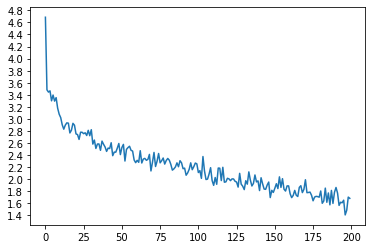

In [19]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 20000, print_every=5000, plot_every=100, learning_rate=0.01)

### Perform model evaluation

In [20]:
evaluateRandomly(encoder1, attn_decoder1)

> je suis trop fatigue pour continuer de marcher .
= i am too tired to keep on walking .
< i m too tired to die . <EOS>

> tu es tres raffine .
= you re very sophisticated .
< you re very sophisticated . <EOS>

> je suis tellement desolee !
= i m so sorry .
< i m so sorry . <EOS>

> je ne suis pas plus intelligent que lui .
= i m not as intelligent as he is .
< i m not what anymore than i am . <EOS>

> tu as de la chance .
= you re fortunate .
< you re in the . <EOS>

> je ne vais nulle part .
= i am not going anywhere .
< i m going to you you <EOS>

> nous sommes bourres .
= we re plastered .
< we re teachers . <EOS>

> il s ameliore petit a petit .
= he is getting better bit by bit .
< he is playing to to . . <EOS>

> je suis en train de griller du poisson .
= i am grilling fish .
< i am playing . <EOS>

> il est professeur d anglais a leeds .
= he is a professor of english at leeds .
< he is in the . . <EOS>



### Visualize attention
A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run plt.matshow(attentions) to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

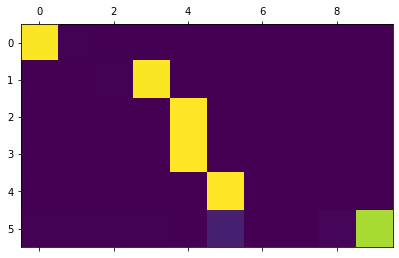

In [21]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

# plt.title('Confusion matrix')
# plt.colorbar()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
plt.show()


For a better viewing experience we will do the extra work of adding axes and labels:

In [22]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


input = elle a cinq ans de moins que moi .
output = she is always years with me . . <EOS>


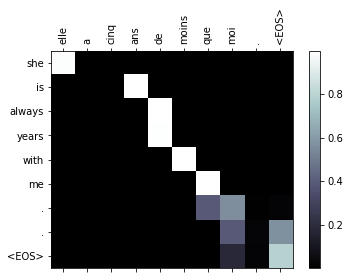

input = elle est trop petit .
output = she is too busy . <EOS>


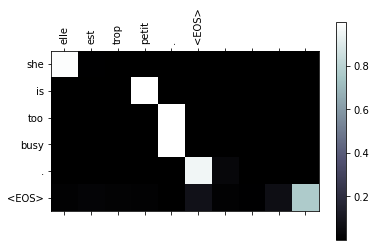

input = je ne crains pas de mourir .
output = i m not afraid to die . <EOS>


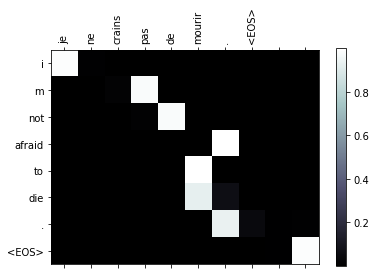

input = c est un jeune directeur plein de talent .
output = he is a of the . . <EOS>


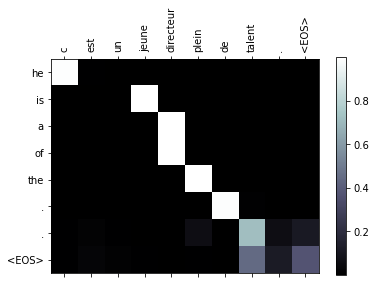

In [23]:
evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

# **References**

- [1] NLP and Computer Vision_DLMAINLPCV01 Course Book
- [2] https://opennmt.net/
- [3] https://github.com/OpenNMT/OpenNMT-py#quickstart


Copyright © 2022 IU International University of Applied Sciences